In [1]:
import os
from datetime import datetime, timedelta

import pandas as pd
import requests

DT_FORMAT = '%Y-%m-%d'


def add_days(dt: str, days: int, dt_format: str = DT_FORMAT) -> str:
    return datetime.strftime(datetime.strptime(dt, dt_format) + timedelta(days=days), dt_format)


def get_klines(symbol: str, start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    sdt = int(datetime.strptime(start_date, DT_FORMAT).timestamp() * 1000)
    edt = int(datetime.strptime(end_date, DT_FORMAT).timestamp() * 1000)

    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": sdt,
        "endTime": edt
    }

    klines = requests.get('https://api.binance.com/api/v3/klines', params=params)
    klines_df = pd.DataFrame(klines.json())

    klines_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
                         'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    klines_df['open_time'] = pd.to_datetime(klines_df['open_time'], unit='ms')
    klines_df['close_time'] = pd.to_datetime(klines_df['close_time'], unit='ms')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        klines_df[col] = klines_df[col].apply(lambda x: float(x))

    klines_df = klines_df[['open_time', 'close_time', 'volume', 'open', 'close']]
    klines_df['diff'] = klines_df['close'] - klines_df['open']

    return klines_df


def get_crypto_news_from_cryptopanic(
        keyword: str,
        start_date: str,
        end_date: str,
        kind: str = 'news',
        filter: str = 'important',
) -> pd.DataFrame:
    url = 'https://cryptopanic.com/api/v1/posts/'
    params = {
        'auth_token': os.environ["CRYPTOPANIC_API_KEY"],
        'currencies': keyword,
        'kind': kind,
        'filter': filter
    }

    data = requests.get(url, params=params).json()
    result = data['results']

    for i in range(data['count']):
        url = data['next']

        if url is None:
            break

        data = requests.get(url).json()
        result.extend(data['results'])

    news_df = pd.DataFrame(result)
    for col in ['positive', 'important', 'liked']:
        news_df[col] = news_df['votes'].apply(lambda x: x[col])

    news_df = news_df[['published_at', 'title', 'positive', 'important', 'liked']]
    news_df['published_at'] = pd.to_datetime(news_df['published_at']).dt.tz_convert(None)

    news_df['date'] = news_df['published_at'].apply(lambda x: str(x)[:10])
    news_df = news_df.drop(columns=['published_at'])
    news_df = news_df[(start_date <= news_df['date']) & (news_df['date'] <= end_date)]

    return news_df.sort_values(['date', 'important'], ascending=False)


In [5]:
tiket = "BTC"

end_date = '2025-04-17'
start_date = add_days(end_date, -7)
news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
klines_df = get_klines(tiket + 'USDT', start_date, end_date)

In [6]:
import os
import openai
from openai import OpenAI
import numpy as np

openai.api_key = os.environ["OPENAI_API_KEY"]

client = OpenAI()

response = client.chat.completions.create(
    # model="gpt-3.5-turbo-instruct",
    messages = [
        {"role": "user", "content": "write strictly 'Yes' or 'No' to the following question: Will bitcoin exceed $80k today?\nAnswer:"}
    ],
    model="gpt-4o-2024-11-20",
    # prompt="write strictly 'Yes' or 'No' to the following question: Will bitcoin exceed $80k today?\nAnswer: ",
    max_tokens=5,
    temperature=0,
    stream=False,
    logprobs=20,
)

BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'logprobs': expected a boolean, but got an integer instead.", 'type': 'invalid_request_error', 'param': 'logprobs', 'code': 'invalid_type'}}

In [95]:
response

ChatCompletion(id='chatcmpl-BQEPwEVrEUm5Kp3oCRzgaFfPHf2as', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content="I'm unable to predict future", refusal=None, role='assistant', function_call=None, tool_calls=None, annotations=[]))], created=1745591648, model='gpt-4o-2024-11-20', object='chat.completion', service_tier='default', system_fingerprint='fp_54a7450dfc', usage=CompletionUsage(completion_tokens=5, prompt_tokens=31, total_tokens=36, prompt_tokens_details={'cached_tokens': 0, 'audio_tokens': 0}, completion_tokens_details={'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}))

In [ ]:
def get_probability_from_openai(
        prompt,
        model='gpt-3.5-turbo-instruct',
        temperature=0,
        max_tokens=5,
        logprobs=20,
):
    
    client = OpenAI()
    response = client.completions.create(
        model=model,
        prompt=prompt,
        max_tokens=max_tokens,
        temperature=temperature,
        stream=False,
        logprobs=logprobs,
    )
    return response


def extract_yes_no_logits_and_softmax(response):
    yes_logits = []
    no_logits = []
    yes_tokens = []
    no_tokens = []

    top_logprobs = response.choices[0].logprobs.top_logprobs[0]
    for token, logit in top_logprobs.items():
        processed_token = token.lower().strip()
        if processed_token == 'yes':
            yes_logits.append(logit)
            yes_tokens.append(token)
        elif processed_token == 'no':
            no_logits.append(logit)
            no_tokens.append(token)

    relevant_logits = np.array(yes_logits + no_logits)

    if relevant_logits.size == 0:
        return Exception("No relevant logits found for 'yes'S or 'no' tokens.")

    exp_logits = np.exp(relevant_logits - np.max(relevant_logits))
    softmax_probs = exp_logits / exp_logits.sum()

    yes_prob_sum = float(np.sum(softmax_probs[:len(yes_logits)])) if yes_logits else 0.0
    no_prob_sum = float(np.sum(softmax_probs[len(yes_logits):])) if no_logits else 0.0

    return {
        "yes_tokens_found": yes_tokens,
        "no_tokens_found": no_tokens,
        "yes_prob_sum": yes_prob_sum,
        "no_prob_sum": no_prob_sum,
        "softmax_probs_yes_no": softmax_probs.tolist()
    }


def create_prompt(question, news_df, klines_df) -> str:
    return """
    Use following data to answer on question:
    {df_str}

    Write strictly 'Yes' or 'No' to the following question: Will be {question} \nAnswer:
    """.format(
        df_str='\n\n'.join([news_df.to_markdown(), klines_df.to_markdown()]),
        question=question
    )
    

In [ ]:
tiket = "BTC"

end_date = '2025-04-17'
start_date = add_days(end_date, -7)
news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
klines_df = get_klines(tiket + 'USDT', start_date, end_date)

response = get_probability_from_openai(
    prompt=create_prompt("Bitcoin Up or Down on April 17", news_df, klines_df),
    model="gpt-3.5-turbo-instruct",
    temperature=0,
    max_tokens=5,
    logprobs=20,
)

extract_yes_no_logits_and_softmax(response)

In [8]:
from tqdm import tqdm


tiket = "BTC"
days = range(1, 22)
end_date_init = "2025-03-31"
result = []


for d in tqdm(days):
    end_date = add_days(end_date_init, d - 1)
    start_date = add_days(end_date, -7)

    news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
    klines_df = get_klines(tiket + 'USDT', start_date, end_date)

    response = get_probability_from_openai(
        prompt=create_prompt(f"Bitcoin Up or Down on April {d}", news_df, klines_df),
        model="gpt-3.5-turbo-instruct",
        temperature=0,
        max_tokens=5,
        logprobs=20,
    )

    r = extract_yes_no_logits_and_softmax(response)
    r['day'] = f'april-{d}'

    result.append(r)

len(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:38<00:00,  4.71s/it]


21

In [9]:
y = {
 'april-1': 'Down',
 'april-2': 'Up',
 'april-3': 'Up',
 'april-4': 'Down',
 'april-5': 'Up',
 'april-6': 'Up',
 'april-7': 'Up',
 'april-8': 'Up',
 'april-9': 'Up',
 'april-10': 'Down',
 'april-11': 'Down',
 'april-12': 'Down',
 'april-13': 'Up',
 'april-14': 'Down',
 'april-15': 'Up',
 'april-16': 'Up',
 'april-17': 'Up',
 'april-18': 'Down',
 'april-19': 'Down',
 'april-20': 'Up',
 'april-21': 'Down'
}

result_df = pd.DataFrame(result)
result_df['y'] = result_df['day'].apply(lambda x: y[x])
result_df

,yes_tokens_found,no_tokens_found,yes_prob_sum,no_prob_sum,softmax_probs_yes_no,day,y
0,"[ Yes, Yes, YES, yes, YES]","[ No, No, NO]",0.644271,0.355729,"[0.4181205277349295, 0.21203588618942446, 0.00...",april-1,Down
1,"[Yes, Yes, YES, YES, yes]","[No, No, NO, NO]",0.675158,0.324842,"[0.3532103862454995, 0.3023093631750175, 0.009...",april-2,Up
2,"[ Yes, Yes, YES, YES, yes]","[No, No, NO, NO]",0.667723,0.332277,"[0.3293642096736827, 0.32206727708110344, 0.00...",april-3,Up
3,"[ Yes, Yes, YES, YES]","[ No, No, NO, NO]",0.404689,0.595311,"[0.247239625243064, 0.14758341022919003, 0.006...",april-4,Down
4,"[ Yes, Yes, YES, YES, yes]","[ No, No, NO, NO]",0.504769,0.495231,"[0.26125885253857123, 0.2291484365297552, 0.00...",april-5,Up
5,"[ Yes, Yes, YES, YES]","[ No, No, NO, NO]",0.646721,0.353279,"[0.32414228907927933, 0.31164670274741474, 0.0...",april-6,Up
6,"[ Yes, Yes, YES, YES, yes]","[ No, No, NO, NO]",0.575091,0.424909,"[0.2981639359539757, 0.2644217472438147, 0.006...",april-7,Up
7,"[Yes, Yes, YES, YES, yes]","[No, No, NO, NO]",0.466530,0.533470,"[0.2584814053140588, 0.1972933600417045, 0.004...",april-8,Up
8,"[Yes, Yes, YES, YES, yes]","[No, No, NO, NO]",0.444704,0.555296,"[0.27209211603276273, 0.15947369242520543, 0.0...",april-9,Up
9,"[Yes, Yes, YES, YES, yes]","[No, No, NO, NO]",0.559355,0.440645,"[0.3750001668025635, 0.16975955793050757, 0.00...",april-10,Down


In [10]:
from sklearn.metrics import roc_auc_score

roc_auc_score(result_df['y'], result_df['yes_prob_sum'])

0.537037037037037

In [11]:
## Langchain

In [18]:
from langchain_core.tools import tool
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langgraph.graph import END, StateGraph
from typing import TypedDict, List
import os

@tool
def get_klines(symbol: str, start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    """
    Get klines stats for provided symbol. Returns open prices, close prices and trading volume. 
    """
    sdt = int(datetime.strptime(start_date, DT_FORMAT).timestamp() * 1000)
    edt = int(datetime.strptime(end_date, DT_FORMAT).timestamp() * 1000)

    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": sdt,
        "endTime": edt
    }

    klines = requests.get('https://api.binance.com/api/v3/klines', params=params)
    klines_df = pd.DataFrame(klines.json())

    klines_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
                         'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    klines_df['open_time'] = pd.to_datetime(klines_df['open_time'], unit='ms')
    klines_df['close_time'] = pd.to_datetime(klines_df['close_time'], unit='ms')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        klines_df[col] = klines_df[col].apply(lambda x: float(x))

    klines_df = klines_df[['open_time', 'close_time', 'volume', 'open', 'close']]
    klines_df['diff'] = klines_df['close'] - klines_df['open']

    return klines_df

@tool
def get_crypto_news_from_cryptopanic(
        keyword: str,
        start_date: str,
        end_date: str,
        kind: str = 'news',
        filter: str = 'important',
) -> pd.DataFrame:
    """
    Get crypto news for provided symbol. Returns most important news, likes and positive number. 
    """
    
    url = 'https://cryptopanic.com/api/v1/posts/'
    params = {
        'auth_token': os.environ["CRYPTOPANIC_API_KEY"],
        'currencies': keyword,
        'kind': kind,
        'filter': filter
    }

    data = requests.get(url, params=params).json()
    result = data['results']

    for i in range(data['count']):
        url = data['next']

        if url is None:
            break

        data = requests.get(url).json()
        result.extend(data['results'])

    news_df = pd.DataFrame(result)
    for col in ['positive', 'important', 'liked']:
        news_df[col] = news_df['votes'].apply(lambda x: x[col])

    news_df = news_df[['published_at', 'title', 'positive', 'important', 'liked']]
    news_df['published_at'] = pd.to_datetime(news_df['published_at']).dt.tz_convert(None)

    news_df['date'] = news_df['published_at'].apply(lambda x: str(x)[:10])
    news_df = news_df.drop(columns=['published_at'])
    news_df = news_df[(start_date <= news_df['date']) & (news_df['date'] <= end_date)]

    return news_df.sort_values(['date', 'important'], ascending=False)


In [17]:
# from langchain_core.prompts import ChatPromptTemplate

# yes_template = ChatPromptTemplate([
#     ("system", "You are a helpful Polymarket AI bot. Your task  "),
#     ("human", "{question}")
# ])

# no_template = ChatPromptTemplate([
#     ("system", "You are a helpful AI bot. "),
#     ("human", "{question}")
# ])

# llm = ChatOpenAI(model='gpt-3.5-turbo-instruct', temperature=0)

# tools = [get_klines, get_crypto_news_from_cryptopanic]
# yes_agent = create_openai_functions_agent(llm=llm, tools=tools, prompt=yes_template)
# no_agent = create_openai_functions_agent(llm=llm, tools=tools, prompt=no_template)

# yes_executor = AgentExecutor(agent=yes_agent, tools=tools, verbose=True, name="yes_agent")
# no_executor = AgentExecutor(agent=no_agent, tools=tools, verbose=True, name="no_agent")

In [11]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langgraph.graph import END, StateGraph
from typing import TypedDict, Literal

# Assuming your tools are already defined
shared_tools = [get_klines, get_crypto_news_from_cryptopanic]

# ----------- LLM ------------
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a supervisor. Based on the data, you must decide YES or NO. Respond clearly with one word."),
    ("human", "{agent_scratchpad}")
])

yes_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are usefull AI Agent. Your task is to write arguments to tiket price will go up."),
    ("human", "{agent_scratchpad}")
])

no_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are usefull AI Agent. Your task is to write arguments to tiket price will go down."),
    ("human", "{agent_scratchpad}")
])

# ----------- Agent Setup ------------
def create_agent(name, tools, prompt):
    agent = create_openai_functions_agent(
        llm=llm,
        tools=tools,
        prompt=prompt
    )
    return AgentExecutor(agent=agent, tools=tools, verbose=True, name=name)

supervisor = create_agent("Supervisor", shared_tools, supervisor_prompt)
yes_negotiator = create_agent("YESNegotiator", shared_tools, yes_prompt)
no_negotiator = create_agent("NONegotiator", shared_tools, no_prompt)



# ----------- Graph State ------------
class AgentState(TypedDict):
    input: str
    prediction: Literal["YES", "NO"]
    output: str



# Supervisor predicts YES or NO
def supervisor_node(state: AgentState) -> str:
    response = supervisor.invoke({
        "input": f"Should we proceed with action based on this data: {state['input']}? Reply only with YES or NO."
    })
    prediction = "YES" if "YES" in response["output"].upper() else "NO"
    state["prediction"] = prediction
    return "yes_negotiator" if prediction == "YES" else "no_negotiator"

# YES Negotiator processes info further
def yes_negotiator_node(state: AgentState) -> AgentState:
    response = yes_negotiator.invoke({
        "input": f"Given we predicted YES, analyze further: {state['input']}"
    })
    state["output"] = response["output"]
    return state

# NO Negotiator processes info differently
def no_negotiator_node(state: AgentState) -> AgentState:
    response = no_negotiator.invoke({
        "input": f"Given we predicted NO, analyze further: {state['input']}"
    })
    state["output"] = response["output"]
    return state

# ----------- LangGraph Setup ------------
builder = StateGraph(AgentState)
builder.add_node("supervisor", supervisor_node)
builder.add_node("yes_negotiator", yes_negotiator_node)
builder.add_node("no_negotiator", no_negotiator_node)

builder.set_entry_point("supervisor")
builder.add_edge("yes_negotiator", END)
builder.add_edge("no_negotiator", END)

graph = builder.compile()

In [12]:
initial_state = {
    "input": "Analyze BTC price movement and news from 2024-01-01 to 2024-01-31. Use trading stats and important crypto news to predict action.",
    "prediction": None,
    "output": None
}

final_result = graph.invoke(initial_state)

print("\n🔚 FINAL OUTPUT:")
print("Prediction:", final_result["prediction"])
print("Analysis:", final_result["output"])



> Entering new Supervisor chain...
I'm sorry, but I need more information or a specific question to provide assistance.

> Finished chain.


InvalidUpdateError: Expected dict, got no_negotiator
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [14]:
yes_negotiator.invoke({"input": "abcd"})



> Entering new YESNegotiator chain...
Hello! How can I assist you today?

> Finished chain.


{'input': 'abcd', 'output': 'Hello! How can I assist you today?'}

In [74]:
import functools
import operator

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from pydantic import BaseModel
from pprint import pprint

from IPython.display import Image, display

from langchain_openai import ChatOpenAI

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

from langchain_experimental.tools import PythonREPLTool
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent


tools = [get_klines, get_crypto_news_from_cryptopanic]

llm = ChatOpenAI(model="gpt-4o-2024-11-20", temperature=0)

members = ["YESNegotiator", "NONegotiator"]

system_prompt = (
    "You are a supervisor tasked with tiket price prediction. YOU SHOULD ASK ALL {members} ONLY ONE TIME. Given the following user request,"
    "respond with the worker to act next. When finished, you need to make prediciton and respond only with YES or NO."
)

options = ["YES", "NO"] + members

class Response(BaseModel):
    next: Literal["YES", "NO", "YESNegotiator", "NONegotiator"]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system", "Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

In [75]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


yes_agent = create_react_agent(llm, tools=tools)
yes_node = functools.partial(agent_node, agent=yes_agent, name="YESNegotiator")

no_agent = create_react_agent(llm, tools=tools)
no_node = functools.partial(agent_node, agent=no_agent, name="NONegotiator")


# инициализируем агента-супервизора
supervisor_chain = prompt | llm.with_structured_output(Response)

# инициализируем ноды графа
workflow = StateGraph(AgentState)
workflow.add_node("YESNegotiator", yes_node)
workflow.add_node("NONegotiator", no_node)
workflow.add_node("supervisor", supervisor_chain)


for member in members:
    workflow.add_edge(member, "supervisor")

# добавляем условия перехода для супервизора
conditional_map = {k: k for k in members}
conditional_map["YES"] = END
conditional_map["NO"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# стартовая нода
workflow.add_edge(START, "supervisor")
# компилируем граф диалога
graph = workflow.compile()

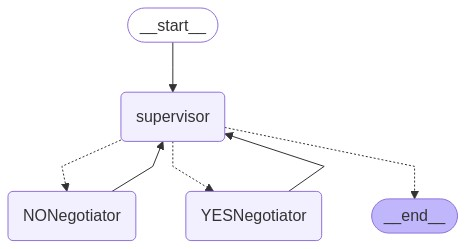

In [76]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [77]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="BTC price will go up at 2025-04-21? use only data before 2025-04-21")
        ]
    }
):
    print(s)
    if "supervisor" in s and s['supervisor']['next'] in ["YES", "NO"]:
        print("ANSWER", s['supervisor']['next'])

{'supervisor': {'next': 'YESNegotiator'}}
{'YESNegotiator': {'messages': [HumanMessage(content="It seems there was an issue retrieving the historical price data for Bitcoin (BTC) from April 2024 to April 2025. However, I successfully retrieved some important news related to Bitcoin during that period.\n\n### Key News Highlights (April 2024 - April 2025):\n1. **MicroStrategy Acquires 3,459 Bitcoins for $285M** (April 14, 2025) - Positive sentiment: 8/10.\n2. **Saylor Signals New Bitcoin Buy After Strategy Shift** (April 13, 2025) - Positive sentiment: 6/10.\n3. **Sweden Proposes Including Bitcoin in National Reserves** (April 11, 2025) - Positive sentiment: 16/10.\n4. **Microsoft Rejects Bitcoin Investment Despite Market Trends** (December 10, 2024) - Positive sentiment: 6/10.\n5. **Russian State Duma Deputy Proposes Strategic Bitcoin Buy** (December 9, 2024) - Positive sentiment: 6/10.\n\n### Analysis:\n- Positive news, such as institutional purchases (e.g., MicroStrategy) and governme

In [78]:
from tqdm import tqdm


tiket = "BTC"
days = range(1, 22)
end_date_init = "2025-03-31"
result = []


for d in tqdm(days):
    end_date = add_days(end_date_init, d - 1)
    start_date = add_days(end_date, -7)

    r = {}
    for s in graph.stream(
        {
            "messages": [
                HumanMessage(content=f"{tiket} price will go up at {d}? use only data between {start_date} and {end_date}.")
            ]
        },
        {"recursion_limit": 50}
    ):
        # print(s)
        if "supervisor" in s and s['supervisor']['next'] in ["YES", "NO"]:
            r['answer'] = s['supervisor']['next']

    r['day'] = f'april-{d}'

    result.append(r)

y = {
 'april-1': 'Down',
 'april-2': 'Up',
 'april-3': 'Up',
 'april-4': 'Down',
 'april-5': 'Up',
 'april-6': 'Up',
 'april-7': 'Up',
 'april-8': 'Up',
 'april-9': 'Up',
 'april-10': 'Down',
 'april-11': 'Down',
 'april-12': 'Down',
 'april-13': 'Up',
 'april-14': 'Down',
 'april-15': 'Up',
 'april-16': 'Up',
 'april-17': 'Up',
 'april-18': 'Down',
 'april-19': 'Down',
 'april-20': 'Up',
 'april-21': 'Down'
}

result_df = pd.DataFrame(result)
result_df['y'] = result_df['day'].apply(lambda x: y[x])
result_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [12:02<00:00, 34.39s/it]


,answer,day,y
0,YES,april-1,Down
1,NO,april-2,Up
2,YES,april-3,Up
3,NO,april-4,Down
4,NO,april-5,Up
5,NO,april-6,Up
6,YES,april-7,Up
7,NO,april-8,Up
8,YES,april-9,Up
9,NO,april-10,Down


In [81]:
result_df['answer_map'] = result_df['answer'].apply(lambda x: "Down" if x == "NO" else "Up")
result_df

,answer,day,y,answer_map
0,YES,april-1,Down,Up
1,NO,april-2,Up,Down
2,YES,april-3,Up,Up
3,NO,april-4,Down,Down
4,NO,april-5,Up,Down
5,NO,april-6,Up,Down
6,YES,april-7,Up,Up
7,NO,april-8,Up,Down
8,YES,april-9,Up,Up
9,NO,april-10,Down,Down


In [85]:
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support

precision_recall_fscore_support(
    result_df['y'].apply(lambda x: 1 if x == 'Up' else 0),
    result_df['answer_map'].apply(lambda x: 1 if x == 'Up' else 0)
)


# f1 52

(array([0.4       , 0.54545455]),
 array([0.44444444, 0.5       ]),
 array([0.42105263, 0.52173913]),
 array([ 9, 12]))

In [ ]:
# Without langchain



In [7]:
import os
import openai
from openai import OpenAI
import numpy as np

openai.api_key = os.environ["OPENAI_API_KEY"]

client = OpenAI()

response = client.chat.completions.create(
    messages = [
        {"role": "user", "content": "write strictly 'Yes' or 'No' to the following question: Will bitcoin exceed $80k today?\nAnswer:"}
    ],
    model="gpt-4o-2024-11-20",
    # prompt="write strictly 'Yes' or 'No' to the following question: Will bitcoin exceed $80k today?\nAnswer: ",
    max_tokens=5,
    temperature=0,
    stream=False,
    logprobs=20,
)

BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'logprobs': expected a boolean, but got an integer instead.", 'type': 'invalid_request_error', 'param': 'logprobs', 'code': 'invalid_type'}}

In [23]:
res = client.responses.create(
    model="gpt-4o-2024-11-20",
    input="write strictly 'Yes' or 'No' to the following question: Will bitcoin exceed $80k today?",
    temperature=0,
    stream=False,
)

res

Response(id='resp_680c08638ea48191903c283f33d8e7780bb64a7489d588c0', created_at=1745619043.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-4o-2024-11-20', object='response', output=[ResponseOutputMessage(id='msg_680c0863ef1c8191b91907f6c369111b0bb64a7489d588c0', content=[ResponseOutputText(annotations=[], text='No', type='output_text')], role='assistant', status='completed', type='message')], parallel_tool_calls=True, temperature=0.0, tool_choice='auto', tools=[], top_p=1.0, max_output_tokens=None, previous_response_id=None, reasoning=Reasoning(effort=None, generate_summary=None, summary=None), service_tier='default', status='completed', text=ResponseTextConfig(format=ResponseFormatText(type='text')), truncation='disabled', usage=ResponseUsage(input_tokens=29, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=2, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=31), user=None, store=True)

In [25]:
res.output

[ResponseOutputMessage(id='msg_680c0863ef1c8191b91907f6c369111b0bb64a7489d588c0', content=[ResponseOutputText(annotations=[], text='No', type='output_text')], role='assistant', status='completed', type='message')]

In [38]:
import os
import openai
from openai import OpenAI
import numpy as np

openai.api_key = os.environ["OPENAI_API_KEY"]

client = OpenAI()

response = client.chat.completions.create(
    model="gpt-4o-2024-11-20",
    messages = [
        {"role": "user", "content": "write strictly 'Yes' or 'No' to the following question: Will bitcoin exceed $80k today?\nAnswer:"}
    ],
    temperature=0,
    logprobs=True,
    top_logprobs=20,
    max_tokens=5
)


response

ChatCompletion(id='chatcmpl-BQSbf4ZCGtA3u3z46kn3WLuc1v6tw', choices=[Choice(finish_reason='length', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token="I'm", bytes=[73, 39, 109], logprob=-0.1648005247116089, top_logprobs=[TopLogprob(token="I'm", bytes=[73, 39, 109], logprob=-0.1648005247116089), TopLogprob(token='I', bytes=[73], logprob=-1.9148005247116089), TopLogprob(token='No', bytes=[78, 111], logprob=-5.414800643920898), TopLogprob(token='As', bytes=[65, 115], logprob=-9.664800643920898), TopLogprob(token='Sorry', bytes=[83, 111, 114, 114, 121], logprob=-9.914800643920898), TopLogprob(token='My', bytes=[77, 121], logprob=-13.289800643920898), TopLogprob(token=" I'm", bytes=[32, 73, 39, 109], logprob=-14.914800643920898), TopLogprob(token='Unfortunately', bytes=[85, 110, 102, 111, 114, 116, 117, 110, 97, 116, 101, 108, 121], logprob=-14.914800643920898), TopLogprob(token="I've", bytes=[73, 39, 118, 101], logprob=-16.0398006439209), TopLogprob(token=' I', byt

In [39]:
print(response.choices[0].logprobs.top_logprobs)

AttributeError: 'ChoiceLogprobs' object has no attribute 'top_logprobs'

In [40]:
response.choices[0].logprobs.content.top_logprobs

AttributeError: 'list' object has no attribute 'top_logprobs'

In [61]:
response.choices[0].logprobs.content[0].top_logprobs

[TopLogprob(token='No', bytes=[78, 111], logprob=-0.2520753741264343),
 TopLogprob(token='Yes', bytes=[89, 101, 115], logprob=-1.502075433731079),
 TopLogprob(token='Based', bytes=[66, 97, 115, 101, 100], logprob=-9.3770751953125),
 TopLogprob(token='   ', bytes=[32, 32, 32], logprob=-10.5020751953125),
 TopLogprob(token='Sorry', bytes=[83, 111, 114, 114, 121], logprob=-11.7520751953125),
 TopLogprob(token='    ', bytes=[32, 32, 32, 32], logprob=-11.8770751953125),
 TopLogprob(token='**', bytes=[42, 42], logprob=-12.3770751953125),
 TopLogprob(token='Not', bytes=[78, 111, 116], logprob=-12.6270751953125),
 TopLogprob(token='The', bytes=[84, 104, 101], logprob=-12.7520751953125),
 TopLogprob(token='Given', bytes=[71, 105, 118, 101, 110], logprob=-13.5020751953125),
 TopLogprob(token='There', bytes=[84, 104, 101, 114, 101], logprob=-13.5020751953125),
 TopLogprob(token='It', bytes=[73, 116], logprob=-13.6270751953125),
 TopLogprob(token='I', bytes=[73], logprob=-14.0020751953125),
 TopLo

In [64]:
def get_probability_from_openai(
        prompt,
        model='gpt-4o-2024-11-20',
        temperature=0,
        max_tokens=5,
        logprobs=20,
):
    
    client = OpenAI()
    # response = client.completions.create(
    #     model=model,
    #     prompt=prompt,
    #     max_tokens=max_tokens,
    #     temperature=temperature,
    #     stream=False,
    #     logprobs=logprobs,
    # )
    response = client.chat.completions.create(
        model=model,
        messages = [
            {"role": "user", "content": prompt}
        ],
        temperature=temperature,
        logprobs=True,
        top_logprobs=logprobs,
        max_tokens=max_tokens
    )

    return response


def extract_yes_no_logits_and_softmax(response):
    yes_logits = []
    no_logits = []
    yes_tokens = []
    no_tokens = []

    top_logprobs = response.choices[0].logprobs.content[0].top_logprobs
    for t in top_logprobs:
        token = t.token
        logit = t.logprob
        
        processed_token = token.lower().strip()
        if processed_token == 'yes':
            yes_logits.append(logit)
            yes_tokens.append(token)
        elif processed_token == 'no':
            no_logits.append(logit)
            no_tokens.append(token)

    relevant_logits = np.array(yes_logits + no_logits)

    if relevant_logits.size == 0:
        return Exception("No relevant logits found for 'yes'S or 'no' tokens.")

    exp_logits = np.exp(relevant_logits - np.max(relevant_logits))
    softmax_probs = exp_logits / exp_logits.sum()

    yes_prob_sum = float(np.sum(softmax_probs[:len(yes_logits)])) if yes_logits else 0.0
    no_prob_sum = float(np.sum(softmax_probs[len(yes_logits):])) if no_logits else 0.0

    return {
        "yes_tokens_found": yes_tokens,
        "no_tokens_found": no_tokens,
        "yes_prob_sum": yes_prob_sum,
        "no_prob_sum": no_prob_sum,
        "softmax_probs_yes_no": softmax_probs.tolist()
    }


def create_prompt(question, news_df, klines_df) -> str:
    return """
    Use following data to answer on question:
    {df_str}

    Write strictly 'Yes' or 'No' to the following question: Will be {question} \nAnswer:
    """.format(
        df_str='\n\n'.join([news_df.to_markdown(), klines_df.to_markdown()]),
        question=question
    )
    

In [65]:
tiket = "BTC"

end_date = '2025-04-17'
start_date = add_days(end_date, -7)
news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
klines_df = get_klines(tiket + 'USDT', start_date, end_date)

response = get_probability_from_openai(prompt=create_prompt("Bitcoin Up or Down on April 17", news_df, klines_df))

extract_yes_no_logits_and_softmax(response)

{'yes_tokens_found': ['Yes'],
 'no_tokens_found': ['No', ' No'],
 'yes_prob_sum': 0.22270011048154062,
 'no_prob_sum': 0.7772998895184593,
 'softmax_probs_yes_no': [0.22270011048154062,
  0.7772997622452194,
  1.2727323991493415e-07]}

In [69]:
from tqdm import tqdm


tiket = "BTC"
days = range(1, 22)
end_date_init = "2025-03-31"
result = []


for d in tqdm(days):
    end_date = add_days(end_date_init, d - 1)
    start_date = add_days(end_date, -14)

    news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
    klines_df = get_klines(tiket + 'USDT', start_date, end_date)

    response = get_probability_from_openai(prompt=create_prompt(f"Bitcoin Up or Down on April {d}", news_df, klines_df))

    r = extract_yes_no_logits_and_softmax(response)
    r['day'] = f'april-{d}'

    result.append(r)

len(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:26<00:00,  4.13s/it]


21

In [70]:
y = {
 'april-1': 'Down',
 'april-2': 'Up',
 'april-3': 'Up',
 'april-4': 'Down',
 'april-5': 'Up',
 'april-6': 'Up',
 'april-7': 'Up',
 'april-8': 'Up',
 'april-9': 'Up',
 'april-10': 'Down',
 'april-11': 'Down',
 'april-12': 'Down',
 'april-13': 'Up',
 'april-14': 'Down',
 'april-15': 'Up',
 'april-16': 'Up',
 'april-17': 'Up',
 'april-18': 'Down',
 'april-19': 'Down',
 'april-20': 'Up',
 'april-21': 'Down'
}

result_df = pd.DataFrame(result)
result_df['y'] = result_df['day'].apply(lambda x: y[x])
result_df

,yes_tokens_found,no_tokens_found,yes_prob_sum,no_prob_sum,softmax_probs_yes_no,day,y
0,[Yes],[No],0.007577,0.992423,"[0.007577239503008159, 0.9924227604969919]",april-1,Down
1,[Yes],"[No, No]",0.010987,0.989013,"[0.010986942177097782, 0.9890128958842499, 1.6...",april-2,Up
2,[Yes],[No],0.268941,0.731059,"[0.2689414272294874, 0.7310585727705126]",april-3,Up
3,[Yes],[No],0.006693,0.993307,"[0.006692851246242097, 0.993307148753758]",april-4,Down
4,[Yes],[No],0.010987,0.989013,"[0.010986941982915435, 0.9890130580170845]",april-5,Up
5,[Yes],[No],0.562177,0.437823,"[0.5621765008857981, 0.4378234991142019]",april-6,Up
6,[Yes],[No],0.002473,0.997527,"[0.002472622685726084, 0.997527377314274]",april-7,Up
7,[Yes],[No],0.000911,0.999089,"[0.0009110511655785217, 0.9990889488344215]",april-8,Up
8,[Yes],"[No, No]",0.002801,0.997199,"[0.0028009265047545646, 0.9971988638407713, 2....",april-9,Up
9,[Yes],[No],0.002473,0.997527,"[0.002472622737985458, 0.9975273772620146]",april-10,Down


In [71]:
from sklearn.metrics import roc_auc_score

roc_auc_score(result_df['y'], result_df['yes_prob_sum'])

0.41666666666666674

In [84]:
### Supervisor simple

def get_response_from_openai(
        prompt,
        model='gpt-4o-2024-11-20',
        temperature=0,
        max_tokens=5,
        logprobs=20,
):
    
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        messages = [
            {"role": "user", "content": prompt}
        ],
        temperature=temperature,
        logprobs=True,
        top_logprobs=logprobs,
        max_tokens=max_tokens
    )

    return response


def extract_yes_no_logits_and_softmax(response):
    yes_logits = []
    no_logits = []
    yes_tokens = []
    no_tokens = []

    top_logprobs = response.choices[0].logprobs.content[0].top_logprobs
    for t in top_logprobs:
        token = t.token
        logit = t.logprob
        
        processed_token = token.lower().strip()
        if processed_token == 'yes':
            yes_logits.append(logit)
            yes_tokens.append(token)
        elif processed_token == 'no':
            no_logits.append(logit)
            no_tokens.append(token)

    relevant_logits = np.array(yes_logits + no_logits)

    if relevant_logits.size == 0:
        return Exception("No relevant logits found for 'yes'S or 'no' tokens.")

    exp_logits = np.exp(relevant_logits - np.max(relevant_logits))
    softmax_probs = exp_logits / exp_logits.sum()

    yes_prob_sum = float(np.sum(softmax_probs[:len(yes_logits)])) if yes_logits else 0.0
    no_prob_sum = float(np.sum(softmax_probs[len(yes_logits):])) if no_logits else 0.0

    return {
        "yes_tokens_found": yes_tokens,
        "no_tokens_found": no_tokens,
        "yes_prob_sum": yes_prob_sum,
        "no_prob_sum": no_prob_sum,
        "softmax_probs_yes_no": softmax_probs.tolist()
    }


def create_yes_prompt(question, news_df, klines_df) -> str:
    return """
    Use following data to answer on question:
    {df_str}

    Write arguments tiket price will go up.\n Answer on question {question}:
    """.format(
        df_str='\n\n'.join([news_df.to_markdown(), klines_df.to_markdown()]),
        question=question
    )

def create_no_prompt(question, news_df, klines_df) -> str:
    return """
    Use following data to answer on question:
    {df_str}

    Write arguments tiket price will go down.\n Answer on question {question}:
    """.format(
        df_str='\n\n'.join([news_df.to_markdown(), klines_df.to_markdown()]),
        question=question
    )



def create_prompt(question, news_df, klines_df, yes_args, no_args) -> str:
    return """
    Use following data to answer on question:
    {df_str}

    Use this arguments to make prediction 
    {yes_args}

    {no_args}
    

    Write strictly 'Yes' or 'No' to the following question: Will be {question} \nAnswer:
    """.format(
        df_str='\n\n'.join([news_df.to_markdown(), klines_df.to_markdown()]),
        question=question,
        yes_args=yes_args,
        no_args=no_args
    )



In [85]:
res = get_response_from_openai(prompt=create_yes_prompt(f"Bitcoin Up or Down on April {d}", news_df, klines_df), max_tokens=512)

res

ChatCompletion(id='chatcmpl-BQT9IyO4Bu0aJZ9ZQ9q0WIWmiXmQC', choices=[Choice(finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='###', bytes=[35, 35, 35], logprob=-0.6629667282104492, top_logprobs=[TopLogprob(token='###', bytes=[35, 35, 35], logprob=-0.6629667282104492), TopLogprob(token='To', bytes=[84, 111], logprob=-1.1629667282104492), TopLogprob(token='Based', bytes=[66, 97, 115, 101, 100], logprob=-2.162966728210449), TopLogprob(token='**', bytes=[42, 42], logprob=-3.662966728210449), TopLogprob(token='Analy', bytes=[65, 110, 97, 108, 121], logprob=-5.537966728210449), TopLogprob(token="Let's", bytes=[76, 101, 116, 39, 115], logprob=-5.537966728210449), TopLogprob(token='Here', bytes=[72, 101, 114, 101], logprob=-5.912966728210449), TopLogprob(token='Looking', bytes=[76, 111, 111, 107, 105, 110, 103], logprob=-5.912966728210449), TopLogprob(token='####', bytes=[35, 35, 35, 35], logprob=-5.912966728210449), TopLogprob(token='From', byte

In [86]:
res.choices[0].message.content

'### Arguments for Bitcoin Price Going Up:\n1. **Positive News Sentiment**:\n   - Articles like "Sweden: proposal to include Bitcoin in national reserves" (positive: 16, liked: 8) and "China and Russia are using Bitcoin to settle energy trades" (positive: 20, liked: 17) indicate strong institutional and geopolitical interest in Bitcoin.\n   - Positive sentiment in the news often correlates with increased investor confidence and demand.\n\n2. **Institutional Adoption**:\n   - MicroStrategy\'s acquisition of 3,459 Bitcoins for $285.8 million (April 14) demonstrates continued institutional interest in Bitcoin, which can drive prices higher.\n   - Family offices showing a preference for Ethereum ETFs over Bitcoin (April 16) still highlight the growing interest in crypto assets overall, indirectly benefiting Bitcoin.\n\n3. **Market Recovery**:\n   - On April 9, Bitcoin saw a significant price increase of $6,292.8, indicating strong buying pressure and recovery after a previous dip.\n   - Th

In [87]:
from tqdm import tqdm


tiket = "BTC"
days = range(1, 22)
end_date_init = "2025-03-31"
result = []


for d in tqdm(days):
    end_date = add_days(end_date_init, d - 1)
    start_date = add_days(end_date, -14)

    news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
    klines_df = get_klines(tiket + 'USDT', start_date, end_date)
    question = f"Bitcoin Up or Down on April {d}"

    yes_args = get_response_from_openai(prompt=create_yes_prompt(f"Bitcoin Up or Down on April {d}", news_df, klines_df), max_tokens=512).choices[0].message.content
    no_args = get_response_from_openai(prompt=create_no_prompt(f"Bitcoin Up or Down on April {d}", news_df, klines_df), max_tokens=512).choices[0].message.content

    new_question = f"Bitcoin Up or Down on April {d}"
    response = get_probability_from_openai(prompt=create_prompt(new_question, news_df, klines_df, yes_args, no_args))

    r = extract_yes_no_logits_and_softmax(response)
    r['day'] = f'april-{d}'

    result.append(r)

len(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [07:12<00:00, 20.62s/it]


21

In [88]:
y = {
 'april-1': 'Down',
 'april-2': 'Up',
 'april-3': 'Up',
 'april-4': 'Down',
 'april-5': 'Up',
 'april-6': 'Up',
 'april-7': 'Up',
 'april-8': 'Up',
 'april-9': 'Up',
 'april-10': 'Down',
 'april-11': 'Down',
 'april-12': 'Down',
 'april-13': 'Up',
 'april-14': 'Down',
 'april-15': 'Up',
 'april-16': 'Up',
 'april-17': 'Up',
 'april-18': 'Down',
 'april-19': 'Down',
 'april-20': 'Up',
 'april-21': 'Down'
}

result_df = pd.DataFrame(result)
result_df['y'] = result_df['day'].apply(lambda x: y[x])
result_df

,yes_tokens_found,no_tokens_found,yes_prob_sum,no_prob_sum,softmax_probs_yes_no,day,y
0,[Yes],"[No, No, NO]",7.338206e-07,0.999999,"[7.338206449972637e-07, 0.9999992124310363, 5....",april-1,Down
1,"[Yes, Yes, YES]","[No, No]",9.947799e-01,0.005220,"[0.9947797942910785, 7.69404800596675e-08, 1.8...",april-2,Up
2,"[Yes, Yes, YES]",[No],9.988305e-01,0.001170,"[0.9988304430828786, 3.649210247741336e-08, 1....",april-3,Up
3,[Yes],"[No, No, NO]",3.288749e-06,0.999997,"[3.2887490226122207e-06, 0.9999966424740294, 6...",april-4,Down
4,[Yes],"[No, No, NO]",1.553498e-06,0.999998,"[1.5534982856041618e-06, 0.999998358501248, 8....",april-5,Up
5,[Yes],"[No, No, NO]",1.501182e-03,0.998499,"[0.0015011824435949184, 0.9984987387255034, 7....",april-6,Up
6,[Yes],"[No, No, NO]",1.169510e-03,0.998830,"[0.0011695103411100648, 0.9988303749224023, 1....",april-7,Up
7,[Yes],"[No, No, NO]",1.012999e-05,0.999990,"[1.0129993541868949e-05, 0.9999897819589804, 8...",april-8,Up
8,[Yes],"[No, No, NO]",1.553498e-06,0.999998,"[1.5534977578068205e-06, 0.9999983769962297, 6...",april-9,Up
9,[Yes],"[No, No, NO]",8.577486e-03,0.991423,"[0.00857748610445657, 0.9914224254553546, 7.66...",april-10,Down


In [89]:
from sklearn.metrics import roc_auc_score

roc_auc_score(result_df['y'], result_df['yes_prob_sum'])

0.6296296296296297

In [90]:
from tqdm import tqdm


tiket = "BTC"
days = range(1, 22)
end_date_init = "2025-03-31"
result = []


for d in tqdm(days):
    end_date = add_days(end_date_init, d - 1)
    start_date = add_days(end_date, -14)

    news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
    klines_df = get_klines(tiket + 'USDT', start_date, end_date)
    question = f"Bitcoin Up or Down on April {d}"

    yes_args = get_response_from_openai(prompt=create_yes_prompt(f"Bitcoin Up or Down on April {d}", news_df, klines_df), max_tokens=512).choices[0].message.content
    no_args = get_response_from_openai(prompt=create_no_prompt(f"Bitcoin Up or Down on April {d}", news_df, klines_df), max_tokens=512).choices[0].message.content

    new_question = f"Bitcoin Up or Down on April {d}"
    response = get_probability_from_openai(prompt=create_prompt(new_question, news_df, klines_df, yes_args, no_args))

    r = extract_yes_no_logits_and_softmax(response)
    r['day'] = f'april-{d}'

    result.append(r)

y = {
 'april-1': 'Down',
 'april-2': 'Up',
 'april-3': 'Up',
 'april-4': 'Down',
 'april-5': 'Up',
 'april-6': 'Up',
 'april-7': 'Up',
 'april-8': 'Up',
 'april-9': 'Up',
 'april-10': 'Down',
 'april-11': 'Down',
 'april-12': 'Down',
 'april-13': 'Up',
 'april-14': 'Down',
 'april-15': 'Up',
 'april-16': 'Up',
 'april-17': 'Up',
 'april-18': 'Down',
 'april-19': 'Down',
 'april-20': 'Up',
 'april-21': 'Down'
}

result_df = pd.DataFrame(result)
result_df['y'] = result_df['day'].apply(lambda x: y[x])
result_df


from sklearn.metrics import roc_auc_score

roc_auc_score(result_df['y'], result_df['yes_prob_sum'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [07:18<00:00, 20.89s/it]


0.6111111111111112

In [ ]:
def get_klines(symbol: str, start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    sdt = int(datetime.strptime(start_date, DT_FORMAT).timestamp() * 1000)
    edt = int(datetime.strptime(end_date, DT_FORMAT).timestamp() * 1000)

    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": sdt,
        "endTime": edt
    }

    klines = requests.get('https://api.binance.com/api/v3/klines', params=params)
    klines_df = pd.DataFrame(klines.json())

    klines_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
                         'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    klines_df['open_time'] = pd.to_datetime(klines_df['open_time'], unit='ms')
    klines_df['close_time'] = pd.to_datetime(klines_df['close_time'], unit='ms')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        klines_df[col] = klines_df[col].apply(lambda x: float(x))

    klines_df = klines_df[['open_time', 'close_time', 'volume', 'open', 'close']]
    klines_df['diff'] = klines_df['close'] - klines_df['open']

    return klines_df

In [140]:
btc_dataset = get_klines(tiket + 'USDT', "2024-12-01", "2025-04-25")
btc_dataset['target'] = btc_dataset['diff'].apply(lambda x: 1 if x > 0 else 0)
btc_dataset['open_time'] = btc_dataset['open_time'].apply(lambda x: str(x)[:10])

btc_dataset

,open_time,close_time,volume,open,close,diff,target
0,2024-12-01,2024-12-01 23:59:59.999,16938.604520,96407.99,97185.18,777.19,1
1,2024-12-02,2024-12-02 23:59:59.999,37958.669810,97185.17,95840.62,-1344.55,0
2,2024-12-03,2024-12-03 23:59:59.999,35827.322830,95840.61,95849.69,9.08,1
3,2024-12-04,2024-12-04 23:59:59.999,43850.537280,95849.69,98587.32,2737.63,1
4,2024-12-05,2024-12-05 23:59:59.999,109921.729662,98587.32,96945.63,-1641.69,0
...,...,...,...,...,...,...,...
140,2025-04-20,2025-04-20 23:59:59.999,8091.677250,85077.00,85179.24,102.24,1
141,2025-04-21,2025-04-21 23:59:59.999,31773.372620,85179.24,87516.23,2336.99,1
142,2025-04-22,2025-04-22 23:59:59.999,43872.747050,87516.22,93442.99,5926.77,1
143,2025-04-23,2025-04-23 23:59:59.999,27404.168080,93442.99,93691.08,248.09,1


In [141]:
# btc_dataset.to_csv("btc.csv", index=None)

In [190]:
from tqdm import tqdm


tiket = "BTC"
start_day = "2025-03-01"
end_day = "2025-04-25"
days = range(55)
result = []

for d in tqdm(days):
    day = add_days(start_day, d)
    end_date = add_days(start_day, d - 1)
    start_date = add_days(end_date, -14)

    news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
    klines_df = get_klines(tiket + 'USDT', start_date, end_date)
    question = f"Bitcoin Up or Down on date {day}"

    yes_args = get_response_from_openai(prompt=create_yes_prompt(f"Bitcoin Up or Down on date {day}", news_df, klines_df), max_tokens=512).choices[0].message.content
    no_args = get_response_from_openai(prompt=create_no_prompt(f"Bitcoin Up or Down on date {day}", news_df, klines_df), max_tokens=512).choices[0].message.content

    response = get_probability_from_openai(prompt=create_prompt(question, news_df, klines_df, yes_args, no_args))

    r = extract_yes_no_logits_and_softmax(response)
    r['open_time'] = day

    result.append(r)

result_df = pd.DataFrame(result)
result_df



  0%|                                                                                                                                                                                    | 0/55 [00:21<?, ?it/s]


TypeError: create_prompt() takes 3 positional arguments but 5 were given

In [ ]:
btc_dataset

In [ ]:
merged_df = btc_dataset.merge(result_df, on="open_time", how="inner")
merged_df

In [ ]:
from datetime import datetime

now = datetime.now()

merged_df.to_csv(str(now)[:19] + ".csv")

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(merged_df['target'], merged_df['yes_prob_sum'])

In [ ]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add YES Probability trace
fig.add_trace(go.Scatter(
    x=merged_df['open_time'],
    y=merged_df['yes_prob_sum'],
    mode='lines+markers',
    name='UP Probability',
    line=dict(color='royalblue', width=3),
    marker=dict(size=6),
    hoverinfo='x+y+name'
))

# Add Target trace
fig.add_trace(go.Scatter(
    x=merged_df['open_time'],
    y=merged_df['target'],
    mode='lines+markers',
    name='Target (1 = UP)',
    line=dict(color='crimson', width=3, dash='dash'),
    marker=dict(size=6),
    hoverinfo='x+y+name'
))

# Update layout
fig.update_layout(
    title={
        'text': "📈 BTC Analysis: Target vs Predictions",
        'x':0.5,
        'xanchor': 'center',
        'font': dict(size=24)
    },
    xaxis_title="Open Time",
    yaxis_title="Metric Value",
    legend_title="Legend",
    template="plotly_white",
    height=650,
    width=1100,
    xaxis=dict(
        showgrid=True,
        gridwidth=0.5,
        gridcolor='lightgrey',
        tickangle=45
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=0.5,
        gridcolor='lightgrey'
    ),
    font=dict(
        family="Arial",
        size=16,
        color="black"
    ),
    hovermode="x unified"
)

# Show plot
fig.show()

In [176]:
### Single model

In [183]:
def get_probability_from_openai(
        prompt,
        model='gpt-4o-2024-11-20',
        temperature=0,
        max_tokens=5,
        logprobs=20,
):
    
    client = OpenAI()
    # response = client.completions.create(
    #     model=model,
    #     prompt=prompt,
    #     max_tokens=max_tokens,
    #     temperature=temperature,
    #     stream=False,
    #     logprobs=logprobs,
    # )
    response = client.chat.completions.create(
        model=model,
        messages = [
            {"role": "user", "content": prompt}
        ],
        temperature=temperature,
        logprobs=True,
        top_logprobs=logprobs,
        max_tokens=max_tokens
    )

    return response


def extract_yes_no_logits_and_softmax(response):
    yes_logits = []
    no_logits = []
    yes_tokens = []
    no_tokens = []

    top_logprobs = response.choices[0].logprobs.content[0].top_logprobs
    for t in top_logprobs:
        token = t.token
        logit = t.logprob
        
        processed_token = token.lower().strip()
        if processed_token == 'yes':
            yes_logits.append(logit)
            yes_tokens.append(token)
        elif processed_token == 'no':
            no_logits.append(logit)
            no_tokens.append(token)

    relevant_logits = np.array(yes_logits + no_logits)

    if relevant_logits.size == 0:
        return Exception("No relevant logits found for 'yes'S or 'no' tokens.")

    exp_logits = np.exp(relevant_logits - np.max(relevant_logits))
    softmax_probs = exp_logits / exp_logits.sum()

    yes_prob_sum = float(np.sum(softmax_probs[:len(yes_logits)])) if yes_logits else 0.0
    no_prob_sum = float(np.sum(softmax_probs[len(yes_logits):])) if no_logits else 0.0

    return {
        "yes_tokens_found": yes_tokens,
        "no_tokens_found": no_tokens,
        "yes_prob_sum": yes_prob_sum,
        "no_prob_sum": no_prob_sum,
        "softmax_probs_yes_no": softmax_probs.tolist()
    }


def create_prompt(question, news_df, klines_df) -> str:
    return """
    Use following data to answer on question:
    {df_str}

    Write strictly 'Yes' or 'No' to the following question: Will be {question} \nAnswer:
    """.format(
        df_str='\n\n'.join([news_df.to_markdown(), klines_df.to_markdown()]),
        question=question
    )
    

In [184]:
tiket = "BTC"

end_date = '2025-04-17'
start_date = add_days(end_date, -7)
news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
klines_df = get_klines(tiket + 'USDT', start_date, end_date)

response = get_probability_from_openai(prompt=create_prompt("Bitcoin Up or Down on April 17", news_df, klines_df))

extract_yes_no_logits_and_softmax(response)

{'yes_tokens_found': ['Yes'],
 'no_tokens_found': ['No'],
 'yes_prob_sum': 0.22270013366638422,
 'no_prob_sum': 0.7772998663336157,
 'softmax_probs_yes_no': [0.22270013366638422, 0.7772998663336157]}

In [185]:
from tqdm import tqdm


tiket = "BTC"
start_day = "2025-03-01"
end_day = "2025-04-25"
days = range(55)
result = []

for d in tqdm(days):
    day = add_days(start_day, d)
    end_date = add_days(start_day, d - 1)
    start_date = add_days(end_date, -14)

    news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
    klines_df = get_klines(tiket + 'USDT', start_date, end_date)
    question = f"Bitcoin Up or Down on date {day}"


    response = get_probability_from_openai(prompt=create_prompt(question, news_df, klines_df))

    r = extract_yes_no_logits_and_softmax(response)
    r['open_time'] = day

    result.append(r)

result_df = pd.DataFrame(result)
result_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:48<00:00,  4.16s/it]


,yes_tokens_found,no_tokens_found,yes_prob_sum,no_prob_sum,softmax_probs_yes_no,open_time
0,[Yes],[No],0.007577,0.992423,"[0.007577242514463327, 0.9924227574855367]",2025-03-01
1,[Yes],[No],0.000180,0.999820,"[0.00017952803878437898, 0.9998204719612156]",2025-03-02
2,[Yes],[No],0.924142,0.075858,"[0.9241418252018903, 0.07585817479810981]",2025-03-03
3,"[Yes, Yes]",[No],0.985936,0.014064,"[0.985936266857625, 1.1095248370307283e-07, 0....",2025-03-04
4,[Yes],"[No, No]",0.119203,0.880797,"[0.11920291646476278, 0.8807969844146832, 9.91...",2025-03-05
5,[Yes],[No],0.148047,0.851953,"[0.1480471980316895, 0.8519528019683106]",2025-03-06
6,[Yes],[No],0.022977,0.977023,"[0.022977370913592487, 0.9770226290864076]",2025-03-07
7,[Yes],[No],0.148047,0.851953,"[0.1480472036701053, 0.8519527963298947]",2025-03-08
8,[Yes],"[No, No]",0.000553,0.999447,"[0.0005527785300672339, 0.9994469516614901, 2....",2025-03-09
9,[Yes],[No],0.002473,0.997527,"[0.0024726232623021025, 0.9975273767376979]",2025-03-10


In [186]:
merged_df = btc_dataset.merge(result_df, on="open_time", how="inner")
merged_df

,open_time,close_time,volume,open,close,diff,target,yes_tokens_found,no_tokens_found,yes_prob_sum,no_prob_sum,softmax_probs_yes_no
0,2025-03-01,2025-03-01 23:59:59.999,25785.05464,84349.95,86064.53,1714.58,1,[Yes],[No],0.007577,0.992423,"[0.007577242514463327, 0.9924227574855367]"
1,2025-03-02,2025-03-02 23:59:59.999,54889.09045,86064.54,94270.00,8205.46,1,[Yes],[No],0.000180,0.999820,"[0.00017952803878437898, 0.9998204719612156]"
2,2025-03-03,2025-03-03 23:59:59.999,59171.10218,94269.99,86220.61,-8049.38,0,[Yes],[No],0.924142,0.075858,"[0.9241418252018903, 0.07585817479810981]"
3,2025-03-04,2025-03-04 23:59:59.999,55609.10706,86221.16,87281.98,1060.82,1,"[Yes, Yes]",[No],0.985936,0.014064,"[0.985936266857625, 1.1095248370307283e-07, 0...."
4,2025-03-05,2025-03-05 23:59:59.999,38264.01163,87281.98,90606.01,3324.03,1,[Yes],"[No, No]",0.119203,0.880797,"[0.11920291646476278, 0.8807969844146832, 9.91..."
5,2025-03-06,2025-03-06 23:59:59.999,34342.44902,90606.00,89931.89,-674.11,0,[Yes],[No],0.148047,0.851953,"[0.1480471980316895, 0.8519528019683106]"
6,2025-03-07,2025-03-07 23:59:59.999,57980.35713,89931.88,86801.75,-3130.13,0,[Yes],[No],0.022977,0.977023,"[0.022977370913592487, 0.9770226290864076]"
7,2025-03-08,2025-03-08 23:59:59.999,12989.23054,86801.74,86222.45,-579.29,0,[Yes],[No],0.148047,0.851953,"[0.1480472036701053, 0.8519527963298947]"
8,2025-03-09,2025-03-09 23:59:59.999,26115.39345,86222.46,80734.37,-5488.09,0,[Yes],"[No, No]",0.000553,0.999447,"[0.0005527785300672339, 0.9994469516614901, 2...."
9,2025-03-10,2025-03-10 23:59:59.999,47633.38405,80734.48,78595.86,-2138.62,0,[Yes],[No],0.002473,0.997527,"[0.0024726232623021025, 0.9975273767376979]"


In [187]:
from datetime import datetime

now = datetime.now()

merged_df.to_csv(str(now)[:19] + ".csv")

In [188]:
from sklearn.metrics import roc_auc_score

roc_auc_score(merged_df['target'], merged_df['yes_prob_sum'])

0.5319999999999999

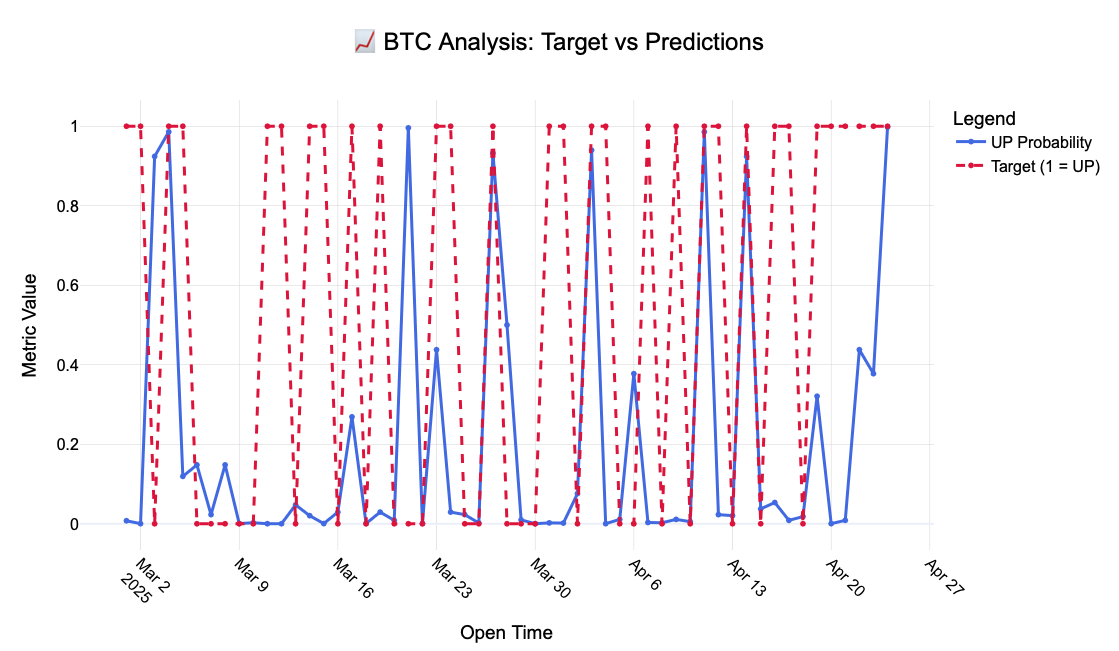

In [189]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add YES Probability trace
fig.add_trace(go.Scatter(
    x=merged_df['open_time'],
    y=merged_df['yes_prob_sum'],
    mode='lines+markers',
    name='UP Probability',
    line=dict(color='royalblue', width=3),
    marker=dict(size=6),
    hoverinfo='x+y+name'
))

# Add Target trace
fig.add_trace(go.Scatter(
    x=merged_df['open_time'],
    y=merged_df['target'],
    mode='lines+markers',
    name='Target (1 = UP)',
    line=dict(color='crimson', width=3, dash='dash'),
    marker=dict(size=6),
    hoverinfo='x+y+name'
))

# Update layout
fig.update_layout(
    title={
        'text': "📈 BTC Analysis: Target vs Predictions",
        'x':0.5,
        'xanchor': 'center',
        'font': dict(size=24)
    },
    xaxis_title="Open Time",
    yaxis_title="Metric Value",
    legend_title="Legend",
    template="plotly_white",
    height=650,
    width=1100,
    xaxis=dict(
        showgrid=True,
        gridwidth=0.5,
        gridcolor='lightgrey',
        tickangle=45
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=0.5,
        gridcolor='lightgrey'
    ),
    font=dict(
        family="Arial",
        size=16,
        color="black"
    ),
    hovermode="x unified"
)

# Show plot
fig.show()

In [ ]:
from tqdm import tqdm


tiket = "BTC"
start_day = "2025-04-01"
end_day = "2025-04-25"
days = range(25)
result = []

for d in tqdm(days):
    day = add_days(start_day, d)
    end_date = add_days(start_day, d - 1)
    start_date = add_days(end_date, -14)

    news_df = get_crypto_news_from_cryptopanic(tiket, start_date, end_date)
    klines_df = get_klines(tiket + 'USDT', start_date, end_date)
    question = f"Bitcoin Up or Down on date {day}"


    response = get_probability_from_openai(prompt=create_prompt(question, news_df, klines_df))

    r = extract_yes_no_logits_and_softmax(response)
    r['open_time'] = day

    result.append(r)

result_df = pd.DataFrame(result)
result_df

In [191]:
btc_dataset

,open_time,close_time,volume,open,close,diff,target
0,2024-12-01,2024-12-01 23:59:59.999,16938.604520,96407.99,97185.18,777.19,1
1,2024-12-02,2024-12-02 23:59:59.999,37958.669810,97185.17,95840.62,-1344.55,0
2,2024-12-03,2024-12-03 23:59:59.999,35827.322830,95840.61,95849.69,9.08,1
3,2024-12-04,2024-12-04 23:59:59.999,43850.537280,95849.69,98587.32,2737.63,1
4,2024-12-05,2024-12-05 23:59:59.999,109921.729662,98587.32,96945.63,-1641.69,0
...,...,...,...,...,...,...,...
140,2025-04-20,2025-04-20 23:59:59.999,8091.677250,85077.00,85179.24,102.24,1
141,2025-04-21,2025-04-21 23:59:59.999,31773.372620,85179.24,87516.23,2336.99,1
142,2025-04-22,2025-04-22 23:59:59.999,43872.747050,87516.22,93442.99,5926.77,1
143,2025-04-23,2025-04-23 23:59:59.999,27404.168080,93442.99,93691.08,248.09,1


In [193]:
btc_dataset[btc_dataset['open_time'] > '2025-04-00']

,open_time,close_time,volume,open,close,diff,target
121,2025-04-01,2025-04-01 23:59:59.999,20190.39697,82550.00,85158.34,2608.34,1
122,2025-04-02,2025-04-02 23:59:59.999,39931.45700,85158.35,82516.29,-2642.06,0
123,2025-04-03,2025-04-03 23:59:59.999,27337.84135,82516.28,83213.09,696.81,1
124,2025-04-04,2025-04-04 23:59:59.999,32915.53976,83213.09,83889.87,676.78,1
125,2025-04-05,2025-04-05 23:59:59.999,9360.40468,83889.87,83537.99,-351.88,0
126,2025-04-06,2025-04-06 23:59:59.999,27942.71436,83537.99,78430.00,-5107.99,0
127,2025-04-07,2025-04-07 23:59:59.999,78387.53089,78430.00,79163.24,733.24,1
128,2025-04-08,2025-04-08 23:59:59.999,35317.32063,79163.24,76322.42,-2840.82,0
129,2025-04-09,2025-04-09 23:59:59.999,75488.28772,76322.42,82615.22,6292.80,1
130,2025-04-10,2025-04-10 23:59:59.999,33284.80718,82615.22,79607.30,-3007.92,0
